<a href="https://colab.research.google.com/github/GokulEpiphany/thesis_temp/blob/main/Updated_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import fastai
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
!pip install fastai --upgrade

In [3]:
from fastai.tabular.all import *


In [4]:

import pandas as pd

df = pd.read_csv('final_data_thesis.csv',header=0)


In [5]:
df.head()

,AGE,GENDER,LA,AO,LVIDd,LVIDs,LVPWd,LVPWs,IVSDd,IVSDs,EF,FS,SV,EDV,ESV,RWT,PASP,PAH,CONC,MR,AR,TR,PR,PE,ASO,ESR,CRP,HEMOGLOBIN,RED BLOOD CELL DISTRIBUTION WIDTH,PLATELETS,NEUTROPHIL,EOSINOPHIL,BASOPHIL,LYMPHOCYTE,MONOCYTE,SODIUM,POTASSIUM,SYSTOLE,DIASTOLE,HR,DOE I - II,DOE III - IV,FEVER,COLD & COUGH,SORETHROAT,CHEST PAIN,JOINT PAIN,PALPITATION,GIDDINESS,PEDAL EDMA,sST2,GROUP
0,1,M,3.2,2.5,4.6,3.0,1.1,1.2,0.8,1.0,65,35,44,62,18,0.59,36,MILD,NO,MILD,NIL,MILD,NIL,NIL,400,13,0.0,12.3,12.5,256000,53.6,4.3,0.0,23.6,7.1,141,4.1,120,70,112,NO,YES,YES,YES,YES,NO,NO,YES,NO,NO,14.0,GROUP I (PHARYNGITIS)
1,10,M,3.0,2.5,4.4,2.4,1.0,1.3,1.0,1.5,63,33,67,89,21,0.45,34,NIL,NO,NIL,TRIVIAL,TRIVIAL,NIL,NIL,400,19,0.0,12.7,12.9,265000,43.5,1.3,0.9,26.0,2.5,139,3.5,120,60,65,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,6.5,GROUP I (PHARYNGITIS)
2,4,M,3.4,2.7,4.3,2.8,1.0,1.1,1.1,1.2,63,33,54,52,19,0.47,34,NIL,NO,TRIVIAL,NIL,NIL,NIL,NIL,0,55,11.0,13.5,12.0,365000,58.9,1.0,0.3,21.0,5.0,140,3.5,130,70,61,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,3.6,GROUP I (PHARYNGITIS)
3,11,M,3.1,2.4,3.5,2.4,1.0,1.2,1.0,1.2,60,30,33,52,19,0.57,42,MILD,NO,NIL,NIL,TRIVIAL,NIL,NIL,800,33,0.0,13.2,13.0,345000,52.6,2.8,1.0,20.0,6.3,136,4.0,120,80,58,NO,YES,YES,NO,YES,NO,NO,YES,NO,NO,15.2,GROUP I (PHARYNGITIS)
4,27,M,3.6,2.9,4.2,3.4,1.1,1.3,1.0,1.1,58,29,60,106,46,0.52,37,MILD,NO,MILD,NIL,MILD,NIL,NIL,400,20,0.0,12.9,13.4,296000,60.0,1.0,0.6,41.6,4.3,140,3.5,120,70,109,NO,YES,YES,NO,YES,NO,NO,YES,NO,NO,14.6,GROUP I (PHARYNGITIS)


In [6]:
df.columns

Index(['AGE', 'GENDER', 'LA', 'AO', 'LVIDd', 'LVIDs', 'LVPWd', 'LVPWs',
       'IVSDd', 'IVSDs', 'EF', 'FS', 'SV', 'EDV', 'ESV', 'RWT', 'PASP', 'PAH',
       'CONC', 'MR', 'AR', 'TR', 'PR', 'PE', 'ASO', 'ESR', 'CRP', 'HEMOGLOBIN',
       'RED BLOOD CELL DISTRIBUTION WIDTH', 'PLATELETS', 'NEUTROPHIL',
       'EOSINOPHIL', 'BASOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'SODIUM',
       'POTASSIUM', 'SYSTOLE', 'DIASTOLE', 'HR', 'DOE I - II', 'DOE III - IV',
       'FEVER', 'COLD & COUGH', 'SORETHROAT', 'CHEST PAIN', 'JOINT PAIN',
       'PALPITATION', 'GIDDINESS', 'PEDAL EDMA', 'sST2', 'GROUP'],
      dtype='object')

In [7]:
len(df.columns)

52

In [8]:
dependant_variable = 'GROUP'

In [9]:
df = df.reindex(np.random.permutation(df.index))

In [10]:
df.head()

,AGE,GENDER,LA,AO,LVIDd,LVIDs,LVPWd,LVPWs,IVSDd,IVSDs,EF,FS,SV,EDV,ESV,RWT,PASP,PAH,CONC,MR,AR,TR,PR,PE,ASO,ESR,CRP,HEMOGLOBIN,RED BLOOD CELL DISTRIBUTION WIDTH,PLATELETS,NEUTROPHIL,EOSINOPHIL,BASOPHIL,LYMPHOCYTE,MONOCYTE,SODIUM,POTASSIUM,SYSTOLE,DIASTOLE,HR,DOE I - II,DOE III - IV,FEVER,COLD & COUGH,SORETHROAT,CHEST PAIN,JOINT PAIN,PALPITATION,GIDDINESS,PEDAL EDMA,sST2,GROUP
95,17,M,3.6,2.4,4.3,3.7,1.1,1.3,1.1,1.3,63,32,51,99,48,0.51,21,NIL,NO,MILD,NIL,NIL,NIL,NIL,400,33,16.89,10.4,12.50,516000,96.0,3.6,0.0,36.0,3.8,140,4.9,120,80,76,NO,NO,NO,YES,YES,NO,YES,NO,NO,NO,20.8,GROUP II (RF)
288,15,F,3.6,3.5,4.9,3.8,1.0,1.2,0.8,1.1,60,30,88,126,38,0.39,38,MILD,NO,NIL,NIL,MILD,NIL,NIL,0,0,0.00,15.3,11.20,405000,51.2,1.9,0.2,37.3,4.0,141,3.9,120,70,71,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,8.9,GROUP IV (CONTROL)
17,25,M,3.0,2.2,4.3,3.0,1.1,1.2,1.1,1.2,59,29,50,84,34,0.51,32,NIL,NO,NIL,NIL,TRIVIAL,NIL,NIL,400,35,0.00,14.0,13.45,278000,60.1,5.3,0.3,35.3,2.6,140,4.2,110,80,100,NO,YES,YES,NO,YES,NO,NO,YES,NO,NO,15.3,GROUP I (PHARYNGITIS)
151,68,F,4.7,2.7,4.6,3.2,0.9,1.0,0.9,1.0,58,29,53,104,51,0.39,39,MILD,NO,MILD,NIL,MILD,NIL,NIL,0,0,45.70,10.3,10.90,399000,86.8,9.6,0.2,49.7,5.3,135,3.7,120,70,62,YES,NO,NO,NO,NO,NO,NO,NO,NO,NO,30.9,GROUP III (RHD)
64,28,F,3.8,2.3,4.9,3.1,1.1,1.3,1.1,1.3,63,33,41,119,78,0.45,22,NIL,NO,SEVERE,SEVERE,TRIVIAL,TRIVIAL,NIL,1600,39,64.20,11.8,10.00,396000,81.7,1.5,0.1,27.3,2.0,140,3.7,120,70,70,NO,NO,YES,YES,NO,YES,YES,YES,YES,YES,28.2,GROUP II (RF)


In [11]:
df.to_csv('shuffled_final.csv',index=False)

In [69]:
procs = [Categorify, FillMissing]
#Lets do a 70-30 split (357 rows, 249 will be used for training, 108 for testing)
N = len(df)
train_n = int( 0.70 * N )
test_n = N - train_n
train_n,test_n


(249, 108)

In [70]:

splits= (list(range(train_n)),list(range(train_n,N)))

In [71]:
dependant_variable = 'GROUP'
cont,cat = cont_cat_split(df, 1, dep_var=dependant_variable) # this preprocess the dataframe to find category/continous variables


In [72]:
df = df.fillna(0)

In [73]:
to = TabularPandas(df, procs, cat, cont, y_names=dependant_variable,y_block=CategoryBlock(), splits=splits)


In [74]:
len(to.train),len(to.valid)


(249, 108)

In [75]:
to.show(3)


,GENDER,PAH,CONC,MR,AR,TR,PR,PE,DOE I - II,DOE III - IV,FEVER,COLD & COUGH,SORETHROAT,CHEST PAIN,JOINT PAIN,PALPITATION,GIDDINESS,PEDAL EDMA,AGE,LA,AO,LVIDd,LVIDs,LVPWd,LVPWs,IVSDd,IVSDs,EF,FS,SV,EDV,ESV,RWT,PASP,ASO,ESR,CRP,HEMOGLOBIN,RED BLOOD CELL DISTRIBUTION WIDTH,PLATELETS,NEUTROPHIL,EOSINOPHIL,BASOPHIL,LYMPHOCYTE,MONOCYTE,SODIUM,POTASSIUM,SYSTOLE,DIASTOLE,HR,sST2,GROUP
95,M,NIL,NO,MILD,NIL,NIL,NIL,NIL,NO,NO,NO,YES,YES,NO,YES,NO,NO,NO,17,3.6,2.4,4.3,3.7,1.1,1.3,1.1,1.3,63,32,51,99,48,0.51,21,400,33,16.889999,10.4,12.50,516000,96.000000,3.6,0.0,36.000000,3.8,140,4.9,120,80,76,20.799999,GROUP II (RF)
288,F,MILD,NO,NIL,NIL,MILD,NIL,NIL,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,15,3.6,3.5,4.9,3.8,1.0,1.2,0.8,1.1,60,30,88,126,38,0.39,38,0,0,0.000000,15.3,11.20,405000,51.200001,1.9,0.2,37.299999,4.0,141,3.9,120,70,71,8.900000,GROUP IV (CONTROL)
17,M,NIL,NO,NIL,NIL,TRIVIAL,NIL,NIL,NO,YES,YES,NO,YES,NO,NO,YES,NO,NO,25,3.0,2.2,4.3,3.0,1.1,1.2,1.1,1.2,59,29,50,84,34,0.51,32,400,35,0.000000,14.0,13.45,278000,60.099998,5.3,0.3,35.299999,2.6,140,4.2,110,80,100,15.300000,GROUP I (PHARYNGITIS)


In [76]:
cont

['AGE',
 'LA',
 'AO',
 'LVIDd',
 'LVIDs',
 'LVPWd',
 'LVPWs',
 'IVSDd',
 'IVSDs',
 'EF',
 'FS',
 'SV',
 'EDV',
 'ESV',
 'RWT',
 'PASP',
 'ASO',
 'ESR',
 'CRP',
 'HEMOGLOBIN',
 'RED BLOOD CELL DISTRIBUTION WIDTH',
 'PLATELETS',
 'NEUTROPHIL',
 'EOSINOPHIL',
 'BASOPHIL',
 'LYMPHOCYTE',
 'MONOCYTE',
 'SODIUM',
 'POTASSIUM',
 'SYSTOLE',
 'DIASTOLE',
 'HR',
 'sST2']

In [77]:
cat

['GENDER',
 'PAH',
 'CONC',
 'MR',
 'AR',
 'TR',
 'PR',
 'PE',
 'DOE I - II',
 'DOE III - IV',
 'FEVER',
 'COLD & COUGH',
 'SORETHROAT',
 'CHEST PAIN',
 'JOINT PAIN',
 'PALPITATION',
 'GIDDINESS',
 'PEDAL EDMA']

In [78]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [79]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,precision_recall_fscore_support

def get_metrics(m,valid_ds,true_y):
  preds = m.predict(valid_ds)
  res=[]
  for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(true_y)==l,
                                                      np.array(preds)==l,
                                                      pos_label=True,average=None)
    res.append(recall[1])
  specificity = sum(res)/len(res)


  return (accuracy_score(true_y,preds),precision_score(true_y,preds,average='macro'),recall_score(true_y,preds,average='macro'),f1_score(true_y,preds,average='macro'),specificity)

In [80]:
def rf(xs, y, n_estimators=40, max_samples=200,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [81]:
m = rf(xs, y);


In [82]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [83]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
50,sST2,0.324916
35,ESR,0.194036
19,LA,0.104868
40,NEUTROPHIL,0.060325
18,AGE,0.059682
34,ASO,0.040821
36,CRP,0.037134
12,SORETHROAT,0.036456
37,HEMOGLOBIN,0.030473
41,EOSINOPHIL,0.018768


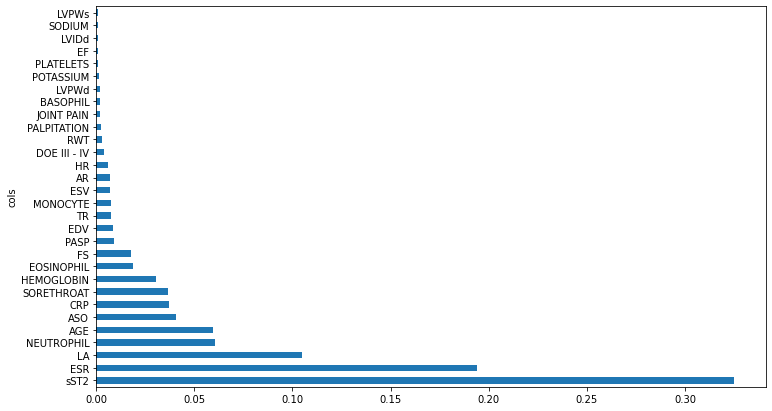

In [84]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [85]:
(accuracy,precision,recall,f1,specificity) = get_metrics(m,valid_xs,valid_y)

In [86]:
(accuracy,precision,recall,f1,specificity)

(0.9907407407407407,
 0.9868421052631579,
 0.9951923076923077,
 0.9908160587772238,
 0.9951923076923077)

In [87]:
preds = m.predict_proba(valid_xs)
true_y = valid_y
roc_auc_score(true_y,preds,multi_class='ovr')

0.9996913580246913

In [91]:
#Model 1 - Blood parameters

In [93]:
cat = []
cont = ['ASO','ESR','CRP','HEMOGLOBIN','RED BLOOD CELL DISTRIBUTION WIDTH',
        'PLATELETS',
 'NEUTROPHIL',
 'EOSINOPHIL',
 'BASOPHIL',
 'LYMPHOCYTE',
 'MONOCYTE',
 'SODIUM',
 'POTASSIUM']

In [94]:
to = TabularPandas(df, procs, cat, cont, y_names=dependant_variable,y_block=CategoryBlock(), splits=splits)


In [95]:
len(to.train),len(to.valid)


(249, 108)

In [96]:
to.show(3)


,ASO,ESR,CRP,HEMOGLOBIN,RED BLOOD CELL DISTRIBUTION WIDTH,PLATELETS,NEUTROPHIL,EOSINOPHIL,BASOPHIL,LYMPHOCYTE,MONOCYTE,SODIUM,POTASSIUM,GROUP
95,400,33,16.889999,10.4,12.50,516000,96.000000,3.6,0.0,36.000000,3.8,140,4.9,GROUP II (RF)
288,0,0,0.000000,15.3,11.20,405000,51.200001,1.9,0.2,37.299999,4.0,141,3.9,GROUP IV (CONTROL)
17,400,35,0.000000,14.0,13.45,278000,60.099998,5.3,0.3,35.299999,2.6,140,4.2,GROUP I (PHARYNGITIS)


In [97]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [98]:
m = rf(xs, y);

In [99]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
1,ESR,0.290127
6,NEUTROPHIL,0.255707
0,ASO,0.103206
2,CRP,0.080960
7,EOSINOPHIL,0.079992
3,HEMOGLOBIN,0.055012
9,LYMPHOCYTE,0.034418
5,PLATELETS,0.030085
10,MONOCYTE,0.027671
4,RED BLOOD CELL DISTRIBUTION WIDTH,0.021354


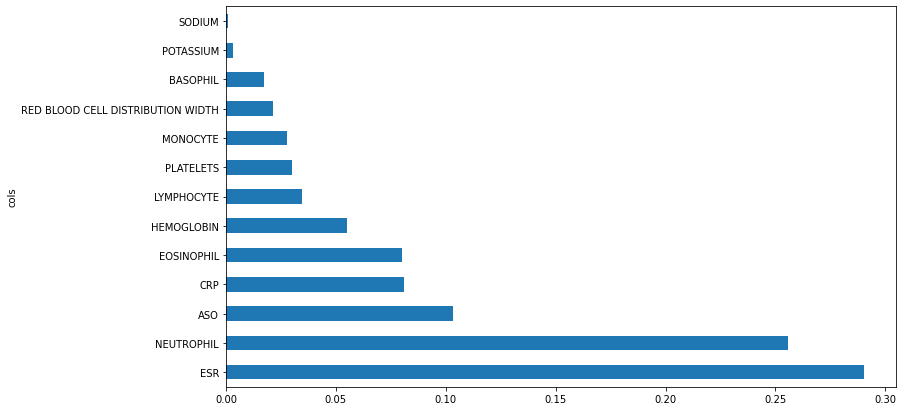

In [100]:
plot_fi(fi[:30]);

In [101]:
(accuracy,precision,recall,f1,specificity) = get_metrics(m,valid_xs,valid_y)
(accuracy,precision,recall,f1,specificity)

(0.9074074074074074,
 0.8723707664884136,
 0.8852258852258853,
 0.8775326184633795,
 0.8852258852258853)

In [102]:
preds = m.predict_proba(valid_xs)
true_y = valid_y
roc_auc_score(true_y,preds,multi_class='ovr')

0.9927944240222608

In [103]:
#Model 2 - ONLY ECHO 
cat = ['PAH',
 'CONC',
 'MR',
 'AR',
 'TR',
 'PR',
 'PE']
cont = ['LA',
 'AO',
 'LVIDd',
 'LVIDs',
 'LVPWd',
 'LVPWs',
 'IVSDd',
 'IVSDs',
 'EF',
 'FS',
 'SV',
 'EDV',
 'ESV',
 'RWT',
 'PASP']
to = TabularPandas(df, procs, cat, cont, y_names=dependant_variable,y_block=CategoryBlock(), splits=splits)
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = rf(xs, y);
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
7,LA,0.361368
4,TR,0.155623
21,PASP,0.107870
16,FS,0.066531
15,EF,0.054627
19,ESV,0.037804
18,EDV,0.034108
3,AR,0.027843
20,RWT,0.022827
17,SV,0.021718


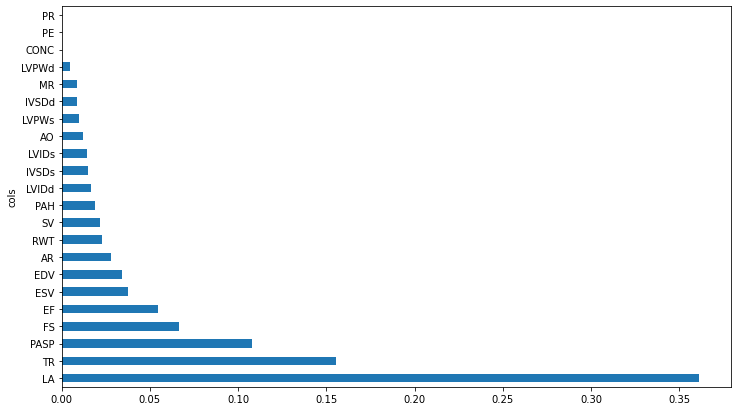

In [104]:
plot_fi(fi[:30]);

In [105]:
(accuracy,precision,recall,f1,specificity) = get_metrics(m,valid_xs,valid_y)
(accuracy,precision,recall,f1,specificity)

(0.8333333333333334,
 0.8406385281385282,
 0.7610653235653236,
 0.7885999308038287,
 0.7610653235653236)

In [106]:
preds = m.predict_proba(valid_xs)
true_y = valid_y
roc_auc_score(true_y,preds,multi_class='ovr')

0.9233750111852949

In [109]:
#Model 3 - SYMPTOMS
cont = []
cat=['DOE I - II',
 'DOE III - IV',
 'FEVER',
 'COLD & COUGH',
 'SORETHROAT',
 'CHEST PAIN',
 'JOINT PAIN',
 'PALPITATION',
 'GIDDINESS',
 'PEDAL EDMA']
to = TabularPandas(df, procs, cat, cont, y_names=dependant_variable,y_block=CategoryBlock(), splits=splits)
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = rf(xs, y);
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
4,SORETHROAT,0.397228
1,DOE III - IV,0.127301
3,COLD & COUGH,0.121757
2,FEVER,0.109059
6,JOINT PAIN,0.085706
5,CHEST PAIN,0.050098
7,PALPITATION,0.049324
9,PEDAL EDMA,0.035984
0,DOE I - II,0.015911
8,GIDDINESS,0.007633


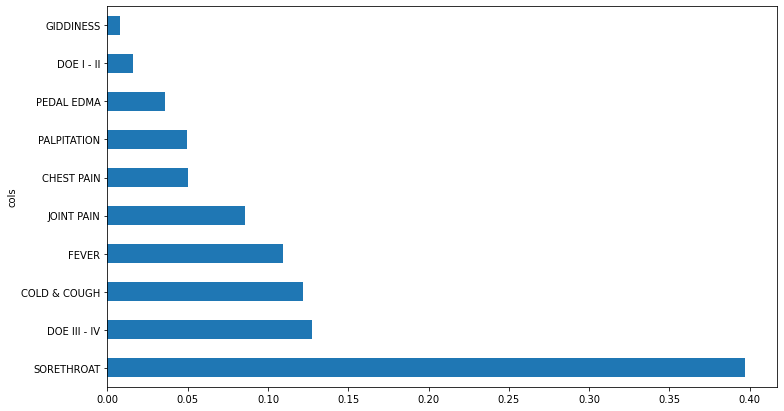

In [110]:
plot_fi(fi[:30]);

In [111]:
(accuracy,precision,recall,f1,specificity) = get_metrics(m,valid_xs,valid_y)
(accuracy,precision,recall,f1,specificity)

(0.7314814814814815,
 0.7604166666666666,
 0.6869276556776557,
 0.6688988095238095,
 0.6869276556776557)

In [112]:
preds = m.predict_proba(valid_xs)
true_y = valid_y
roc_auc_score(true_y,preds,multi_class='ovr')

0.9044748982138167

In [113]:
cat = []
cont = ['ASO','ESR','CRP','HEMOGLOBIN','RED BLOOD CELL DISTRIBUTION WIDTH',
        'PLATELETS',
 'NEUTROPHIL',
 'EOSINOPHIL',
 'BASOPHIL',
 'LYMPHOCYTE',
 'MONOCYTE',
 'SODIUM',
 'POTASSIUM','sST2']

In [114]:
to = TabularPandas(df, procs, cat, cont, y_names=dependant_variable,y_block=CategoryBlock(), splits=splits)


In [115]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = rf(xs, y);
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
13,sST2,0.370567
1,ESR,0.207397
6,NEUTROPHIL,0.117970
0,ASO,0.091926
2,CRP,0.079691
7,EOSINOPHIL,0.060052
10,MONOCYTE,0.020517
5,PLATELETS,0.018832
3,HEMOGLOBIN,0.017122
8,BASOPHIL,0.009460


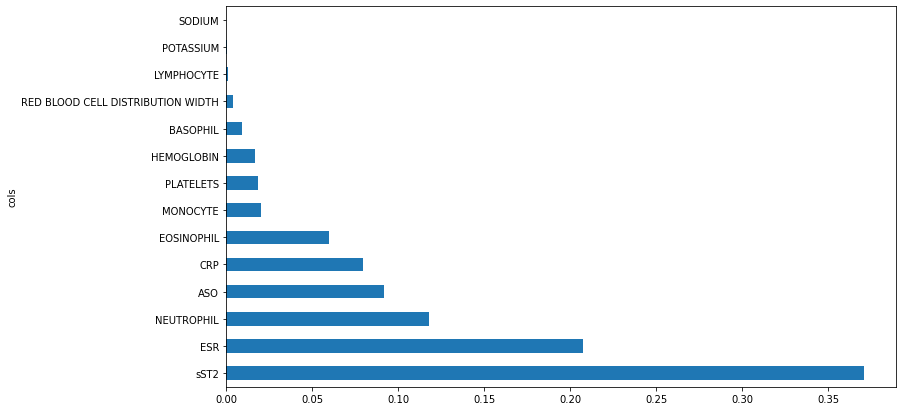

In [116]:
plot_fi(fi[:30]);

In [117]:
(accuracy,precision,recall,f1,specificity) = get_metrics(m,valid_xs,valid_y)
(accuracy,precision,recall,f1,specificity)

(0.9722222222222222,
 0.9548611111111112,
 0.9708867521367521,
 0.9616981110422548,
 0.9708867521367521)

In [118]:
preds = m.predict_proba(valid_xs)
true_y = valid_y
roc_auc_score(true_y,preds,multi_class='ovr')

0.9975227007363532

In [119]:
cat = ['PAH',
 'CONC',
 'MR',
 'AR',
 'TR',
 'PR',
 'PE']
cont = ['LA',
 'AO',
 'LVIDd',
 'LVIDs',
 'LVPWd',
 'LVPWs',
 'IVSDd',
 'IVSDs',
 'EF',
 'FS',
 'SV',
 'EDV',
 'ESV',
 'RWT',
 'PASP','sST2']

In [120]:
to = TabularPandas(df, procs, cat, cont, y_names=dependant_variable,y_block=CategoryBlock(), splits=splits)


In [121]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = rf(xs, y);
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
22,sST2,0.526160
7,LA,0.135951
4,TR,0.062968
16,FS,0.047389
15,EF,0.046483
21,PASP,0.029381
3,AR,0.021064
19,ESV,0.019153
18,EDV,0.018300
2,MR,0.018146


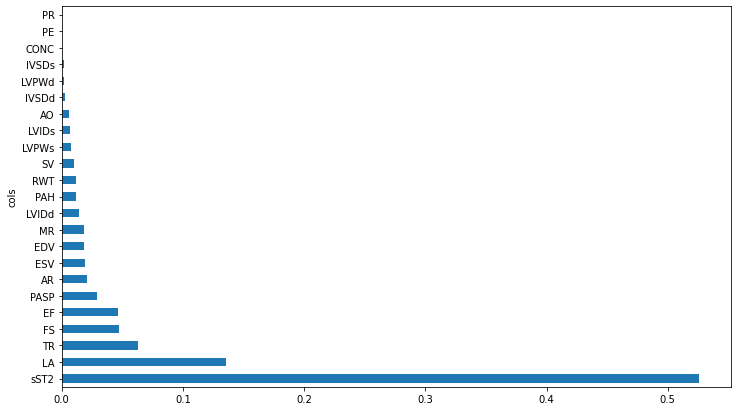

In [122]:
plot_fi(fi[:30]);

In [123]:
(accuracy,precision,recall,f1,specificity) = get_metrics(m,valid_xs,valid_y)
(accuracy,precision,recall,f1,specificity)

(0.8703703703703703,
 0.8836101124236717,
 0.8022359584859585,
 0.8276337189116094,
 0.8022359584859585)

In [124]:
preds = m.predict_proba(valid_xs)
true_y = valid_y
roc_auc_score(true_y,preds,multi_class='ovr')

0.9532945744825178

In [125]:
 cont = ['sST2']
 cat=['DOE I - II',
 'DOE III - IV',
 'FEVER',
 'COLD & COUGH',
 'SORETHROAT',
 'CHEST PAIN',
 'JOINT PAIN',
 'PALPITATION',
 'GIDDINESS',
 'PEDAL EDMA']

In [126]:
to = TabularPandas(df, procs, cat, cont, y_names=dependant_variable,y_block=CategoryBlock(), splits=splits)
to.show(3)

,DOE I - II,DOE III - IV,FEVER,COLD & COUGH,SORETHROAT,CHEST PAIN,JOINT PAIN,PALPITATION,GIDDINESS,PEDAL EDMA,sST2,GROUP
95,NO,NO,NO,YES,YES,NO,YES,NO,NO,NO,20.799999,GROUP II (RF)
288,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,8.900000,GROUP IV (CONTROL)
17,NO,YES,YES,NO,YES,NO,NO,YES,NO,NO,15.300000,GROUP I (PHARYNGITIS)


In [127]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = rf(xs, y);
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
10,sST2,0.575134
4,SORETHROAT,0.204512
6,JOINT PAIN,0.052134
7,PALPITATION,0.046889
3,COLD & COUGH,0.034129
2,FEVER,0.032840
1,DOE III - IV,0.029921
5,CHEST PAIN,0.012783
9,PEDAL EDMA,0.007267
0,DOE I - II,0.002445


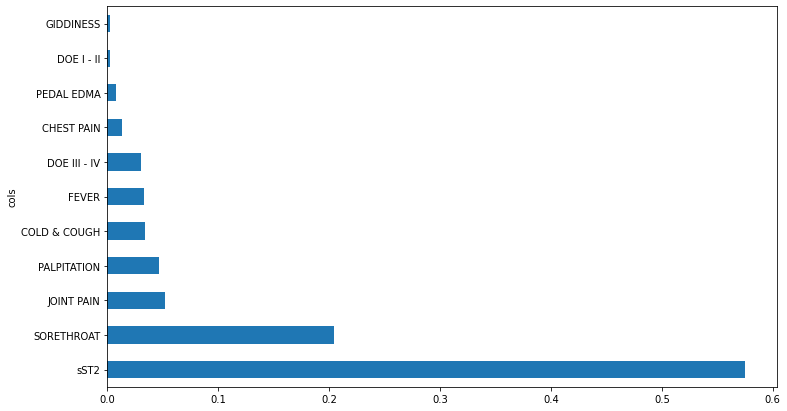

In [128]:
plot_fi(fi[:30]);

In [129]:
(accuracy,precision,recall,f1,specificity) = get_metrics(m,valid_xs,valid_y)
(accuracy,precision,recall,f1,specificity)

(0.9074074074074074,
 0.8878205128205128,
 0.9071657509157509,
 0.8905180533751962,
 0.9071657509157509)

In [130]:
preds = m.predict_proba(valid_xs)
true_y = valid_y
roc_auc_score(true_y,preds,multi_class='ovr')

0.9911770213631914